In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from glob import glob
%matplotlib inline

In [2]:
os.listdir()

['train.zip',
 'aerial-cactus-identification.zip',
 'train.csv',
 '.ipynb_checkpoints',
 'why.ipynb',
 'test',
 'train',
 'sample_submission.csv',
 'test.zip']

In [3]:
train_imgs = glob('train/*')
len(train_imgs)

17500

In [4]:
test_imgs = glob('test/*')
len(test_imgs)

4000

## 데이터확인
This dataset contains a large number of 32 x 32 thumbnail images containing aerial photos of a columnar cactus (Neobuxbaumia tetetzo). Kaggle has resized the images from the original dataset to make them uniform in size. The file name of an image corresponds to its ```id```.  
  
You must create a classifier capable of predicting whether an images contains a cactus.

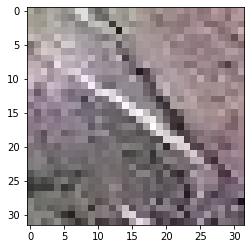

In [5]:
img = tf.io.read_file(train_imgs[0])
img = tf.image.decode_image(img)
plt.imshow(img)
plt.show()

In [6]:
img.shape

TensorShape([32, 32, 3])

In [7]:
train_imgs[0]

'train/a8da764c87b9c67630b4a24a42eeb2f4.jpg'

In [8]:
test_imgs[0]

'test/4d502fd57fe2fe31318f8246a343a57f.jpg'

In [9]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [10]:
train_csv = pd.read_csv('train.csv')
train_csv.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


- 데이터의 크기는 32x32, 3채널..? 일 것이다.  채널수가 다르다면 이후에 에러가 발생할 수 있음.
- train에 대한 label은 train.csv에 존재
- ```id```를 사용해서 submission파일 생성, ```id```는 이미지의 파일명과 동일

## Dataset 생성

그럼.. 사진에 대한 어... 정보는 train에 있는 사진을 읽어서 numpy로 전달하고..  
어.... label은 csv에 id로 접근해서...데이터셋을... 만드나?  
1. 먼저 csv에서 파일명과 label을 가져와서 input_paths리스트를 새롭게 생성한다.
    - fname(train_img_id)의 경우 앞에 train dataset의 경로를 명시해주도록 os.path.join을 활용
    - train, valid 나누기
2. tf.data.Dataset을 사용하면 간단하게 리스트로 전달해주고 dataset을 만들 수 있다.
    - Dataset을 생성하고 값을 확인하려면 다음과 같이 입력
        ```python
        n = next(iter(dataset))
        ```
3. 추가로 경로로 만든 dataset을 map함수를 사용해서 경로 => 이미지로 읽어주는 함수를 적용
    - read_file 함수 정의

In [11]:
train_img_id = train_csv['id']
train_img_label = train_csv['has_cactus']
len(train_img_id), len(train_img_label)

(17500, 17500)

In [12]:
input_paths = []
for fname, label in tqdm(zip(train_img_id, train_img_label)):
    input_paths.append((os.path.join('train', fname), label))
    
len(input_paths)

17500

In [13]:
input_paths[:10]

[('train/0004be2cfeaba1c0361d39e2b000257b.jpg', 1),
 ('train/000c8a36845c0208e833c79c1bffedd1.jpg', 1),
 ('train/000d1e9a533f62e55c289303b072733d.jpg', 1),
 ('train/0011485b40695e9138e92d0b3fb55128.jpg', 1),
 ('train/0014d7a11e90b62848904c1418fc8cf2.jpg', 1),
 ('train/0017c3c18ddd57a2ea6f9848c79d83d2.jpg', 1),
 ('train/002134abf28af54575c18741b89dd2a4.jpg', 0),
 ('train/0024320f43bdd490562246435af4f90b.jpg', 0),
 ('train/002930423b9840e67e5a54afd4768a1e.jpg', 1),
 ('train/00351838ebf6dff6e53056e00a1e307c.jpg', 1)]

### tf.data.Dataset 알아보기

In [14]:
dataset = tf.data.Dataset.from_tensor_slices(np.array(input_paths))

In [15]:
n = next(iter(dataset))
print(n[0], '\n', n[1])

tf.Tensor(b'train/0004be2cfeaba1c0361d39e2b000257b.jpg', shape=(), dtype=string) 
 tf.Tensor(b'1', shape=(), dtype=string)


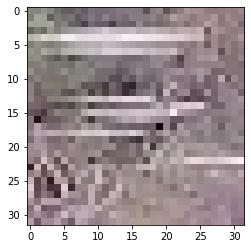

In [16]:
t = tf.io.read_file(n[0])
t = tf.image.decode_image(t)
plt.imshow(t)
plt.show()

In [17]:
def read_img(data):
    img_path = data[0]
    label = data[1]
    label = tf.strings.to_number(label, out_type=tf.int64)
    
    tf_img = tf.io.read_file(img_path)
    img = tf.image.decode_image(tf_img)
    
    return img, label

In [18]:
dataset = dataset.map(read_img)
n = next(iter(dataset))
n[0].shape, n[1]

(TensorShape([32, 32, 3]), <tf.Tensor: shape=(), dtype=int64, numpy=1>)

### train, valid데이터셋 나눠서 데이터셋 생성

In [19]:
train, valid = train_test_split(input_paths, train_size=0.8)

In [20]:
len(train), len(valid)

(14000, 3500)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train))
train_dataset = train_dataset.map(read_img)
train_dataset = train_dataset.shuffle(len(train))
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.repeat()

In [22]:
valid_dataset = tf.data.Dataset.from_tensor_slices(np.array(valid))
valid_dataset = valid_dataset.map(read_img)
valid_dataset = valid_dataset.batch(32)
valid_dataset = valid_dataset.repeat()

## model 생성

In [23]:
inputs = Input((32, 32, 3))

# Feature Extraction
net = Conv2D(32, 3, 1, 'SAME')(inputs)
net = Activation('relu')(net)
net = Conv2D(32, 3, 1, 'SAME')(net)
net = Activation('relu')(net)
net = MaxPooling2D((2,2))(net)
net = BatchNormalization()(net)

net = Conv2D(64, 3, 1, 'SAME')(net)
net = Activation('relu')(net)
net = Conv2D(64, 3, 1, 'SAME')(net)
net = Activation('relu')(net)
net = MaxPooling2D((2,2))(net)
net = BatchNormalization()(net)

# classification
net = Flatten()(net)
net = Dense(512)(net)
net = Activation('relu')(net)
net = BatchNormalization()(net)
net = Dense(1)(net)
output = Activation('sigmoid')(net)

basic_cnn = tf.keras.Model(inputs=inputs, outputs = output, name='basic_cnn')

basic_cnn.summary()

Model: "basic_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        12

In [24]:
basic_cnn.compile(loss = tf.keras.losses.binary_crossentropy,
             optimizer = tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [25]:
es = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
mc = ModelCheckpoint('basic_cnn.h5', monitor='val_accuracy', save_best_only=True)

In [26]:
steps_per_epoch = len(train) // 32
validation_steps = len(valid) // 32

hist = basic_cnn.fit(train_dataset,
                validation_data = valid_dataset,
                validation_steps=validation_steps,
                steps_per_epoch=steps_per_epoch,
                epochs=50,
                callbacks=[es, mc]
                )

Epoch 1/50
437/437 [==============================] - 5s 12ms/step - loss: 0.1493 - accuracy: 0.9467 - val_loss: 0.3029 - val_accuracy: 0.8647
Epoch 2/50
437/437 [==============================] - 2s 6ms/step - loss: 0.0781 - accuracy: 0.9722 - val_loss: 1.0170 - val_accuracy: 0.7572
Epoch 3/50
437/437 [==============================] - 3s 6ms/step - loss: 0.0497 - accuracy: 0.9837 - val_loss: 0.1313 - val_accuracy: 0.9590
Epoch 4/50
437/437 [==============================] - 2s 6ms/step - loss: 0.0365 - accuracy: 0.9874 - val_loss: 0.2245 - val_accuracy: 0.9341
Epoch 5/50
437/437 [==============================] - 2s 6ms/step - loss: 0.0268 - accuracy: 0.9908 - val_loss: 0.7663 - val_accuracy: 0.8159
Epoch 6/50
437/437 [==============================] - 2s 6ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.4826 - val_accuracy: 0.8638
Epoch 7/50
437/437 [==============================] - 2s 6ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.2409 - val_accuracy: 0.9031
Epoch

In [27]:
test_imgs[0]

'test/4d502fd57fe2fe31318f8246a343a57f.jpg'

In [29]:
def test_img_read(path) :
    tf_img = tf.io.read_file(path)
    img = tf.io.decode_image(tf_img)
    return img

In [32]:
test_ds = tf.data.Dataset.from_tensor_slices(test_imgs)
test_ds = test_ds.map(test_img_read)
test_ds = test_ds.batch(32)

In [33]:
pred = basic_cnn.predict(test_ds)

In [45]:
pred = pred.reshape(4000)

In [46]:
test_fname = sub['id']
test_label = pred

sub_file = pd.DataFrame({'id':test_fname, 'has_cactus':test_label}, columns=['id', 'has_cactus'])
sub_file.to_csv('sub.csv', index=False)